In [63]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=SyntaxWarning) 

In [165]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import re

## Read meta data

In [65]:
meta_data = pd.read_csv('data.nosync/phenotypic/ADHD200_phenotypic.csv')
#Expand subject ID
meta_data['ScanDir ID'] = meta_data['ScanDir ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))
#Select columns
meta_data = meta_data[['ScanDir ID', 'Gender', 'DX']]
#Replace values
meta_data['DX'] = meta_data['DX'].replace({0: 'TD', 1: 'ADHD-Combined', 2: 'ADHD-Hyperactive/Impulsive', 3: 'ADHD-Inattentive'})
meta_data['Gender'] = meta_data['Gender'].replace({0: 'Female', 1: 'Male'})

meta_data = meta_data.drop_duplicates('ScanDir ID')
meta_data

,ScanDir ID,Gender,DX
0,1000804,Male,TD
1,1023964,Male,ADHD-Inattentive
2,1057962,Male,ADHD-Combined
3,1099481,Female,ADHD-Combined
4,1127915,Female,TD
...,...,...,...
217,0010127,Male,ADHD-Combined
218,0010128,Male,TD
219,0010129,Female,ADHD-Inattentive
220,0010013,Male,ADHD-Combined


## Read thresholds + file list

In [66]:
threshold_data = pd.read_csv('data.nosync/stats/ADHD200_7_activation_thresholds.csv', sep = ';', index_col='Unnamed: 0')
threshold_data['Subject_ID'] = threshold_data['Subject'].apply(lambda x: re.search("\d{7}", x)[0])
threshold_data['Subject_ID'] = threshold_data['Subject_ID'].apply(lambda x: ''.join(['0' for i in range(7-len(str(x)))]) + str(x))

#Merge with meta data
threshold_data = pd.merge(left = threshold_data, 
                    right = meta_data,
                    left_on= 'Subject_ID',
                    right_on= 'ScanDir ID')
threshold_data = threshold_data.drop('ScanDir ID', axis = 1)
threshold_data

,Subject,10th,25th,50th,75th,90th,Subject_ID,Gender,DX
0,sfnwmrda3662296_session_1_rest_1,-0.475130,-0.223056,0.000132,0.237170,0.503128,3662296,Female,TD
1,sfnwmrda0010097_session_1_rest_1,-0.387366,-0.181843,0.021169,0.231994,0.444593,0010097,Female,TD
2,sfnwmrda0010064_session_1_rest_1,-0.421308,-0.188020,0.019193,0.237111,0.455676,0010064,Male,ADHD-Combined
3,sfnwmrda0010056_session_1_rest_2,-0.435537,-0.209100,0.008325,0.235567,0.474488,0010056,Male,ADHD-Inattentive
4,sfnwmrda4562206_session_1_rest_1,-0.492353,-0.235654,0.008877,0.265443,0.536959,4562206,Female,TD
...,...,...,...,...,...,...,...,...,...
389,sfnwmrda3349205_session_1_rest_1,-0.499194,-0.222867,0.038061,0.322062,0.623349,3349205,Female,ADHD-Inattentive
390,sfnwmrda2054438_session_1_rest_2,-0.678736,-0.329390,0.000314,0.332473,0.687417,2054438,Male,ADHD-Combined
391,sfnwmrda0010107_session_1_rest_1,-0.357489,-0.171575,0.001951,0.179058,0.361544,0010107,Male,ADHD-Inattentive
392,sfnwmrda1127915_session_1_rest_1,-0.462940,-0.233951,-0.011980,0.204279,0.427419,1127915,Female,TD


In [67]:
clean_path = f'data.nosync/stats/ADHD200_7'
file_list = os.listdir(clean_path)
if '.DS_Store' in file_list:
    file_list.remove('.DS_Store')

# Correlation matrix

In [106]:
#Regions
num_of_regions = 7
regions = [f"ROI_{i+1}" for i in range(num_of_regions)]

thresholds = ['10th', '25th', '50th', '75th', '90th']

In [ ]:
binary_data = {}

for i in thresholds:
    binary_data[i] = []
    
temp_threshold_data = threshold_data[threshold_data['DX'] == 'ADHD-Combined']

#For each subject in group
for sub in temp_threshold_data['Subject']:
    #For each threshold
    for thre in thresholds:
        #Get threshold
        threshold = float(threshold_data[threshold_data['Subject'] == sub][thre])
        #Get subject data
        subject = pd.read_csv(f'data.nosync/stats/ADHD200_7/{sub}.csv', sep=';', index_col='Unnamed: 0')
        for i in regions:
            subject[i] = subject[i].apply(lambda x: 1 if x >= threshold else 0)
        binary_data[thre].append(subject)

for key, value in binary_data.items():
    binary_data[key] = pd.concat(value).corr()

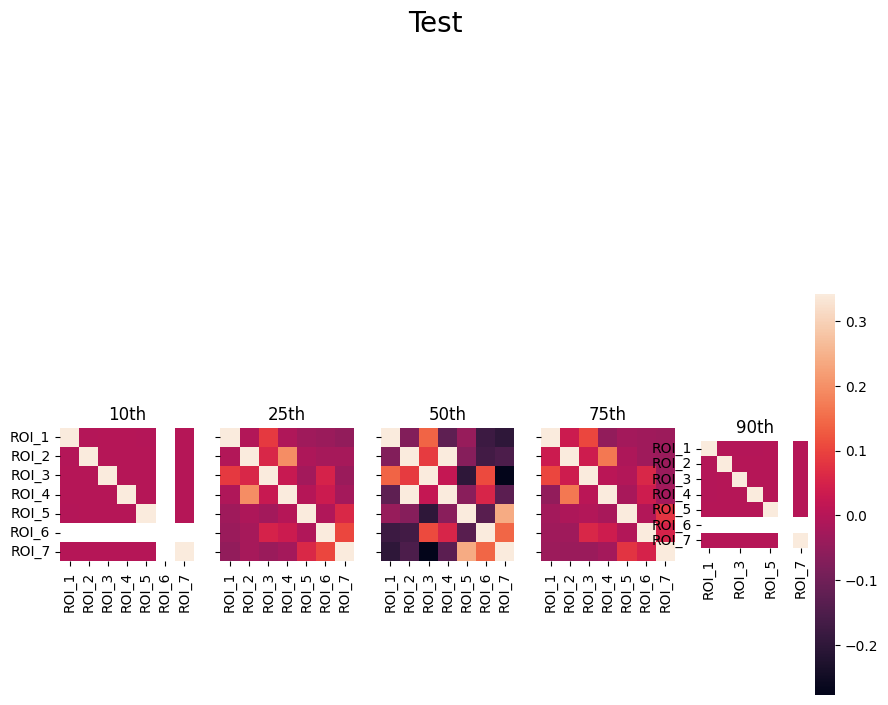

In [187]:
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
fig.suptitle('Test', fontsize = 20)

axs_count = 0

global_min = []
global_max = []


for key, value in binary_data.items():
    #Remove nans and get axis max
    a = value.to_numpy().flatten()
    a = a[~np.isnan(a)]
    a = a[np.logical_not(a==1.0)]
    x_min, x_max = float(min(a)), float(max(a))
    global_min.append(x_min)
    global_max.append(x_max)

for key, value in binary_data.items():
    #Remove nans and get axis max
    a = value.to_numpy().flatten()
    a = a[~np.isnan(a)]
    a = a[np.logical_not(a==1.0)]
    x_min, x_max = float(min(a)), float(max(a))

    cbar_add = True if key == '90th' else False
    
    if key == '10th':
        axs[axs_count].set_ylabel(key)
        
    sns.heatmap(value, 
                square = True, 
                ax = axs[axs_count],
                vmax = max(global_max),
                vmin = min(global_min),
                cbar = cbar_add)

    axs[axs_count].set_title(key)
    axs_count+= 1

for ax in axs.flat:
        ax.label_outer()

In [ ]:
#Make subplot
    fig, axs = plt.subplots(sub_size, sub_size, figsize=(10, 10), tight_layout=True)
    fig.suptitle(title, fontsize = 20)

    temp_rois = regions.copy()

    #Store y axis
    y_max = []
    y_min = []

    for x in range(sub_size):
        for y in range(sub_size):
            #If no ROIs left break
            if len(temp_rois) == 0:
                break
            #If top-right add legend and move to the right
            add_legend = True if [x,y] == [0,sub_size-1] else False
            
            #Create subplot
            sns.kdeplot(data = data, 
                        x = temp_rois[0], 
                        hue= hue_col, 
                        ax = axs[x, y], 
                        legend= add_legend)
            
            #Set title and x-axis range 
            axs[x, y].set_title(temp_rois[0])

            if add_legend:
                sns.move_legend(axs[x, y], 
                                "upper left", 
                                bbox_to_anchor=(1, 1))

            #Keep track of the y axis -> so it can be uniformed
            lim = axs[x,y].get_ylim()
            y_max.append(lim[1])
            y_min.append(lim[0])
            temp_rois.remove(temp_rois[0])

<Axes: >

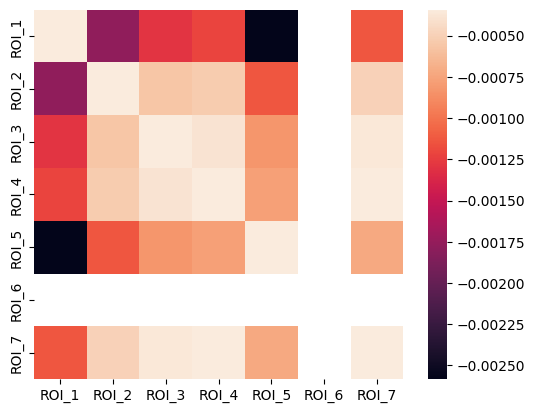

In [164]:
#Remove nans and get axis max
a = binary_data['10th'].to_numpy().flatten()
a = a[~np.isnan(a)]
a = a[np.logical_not(a==1.0)]
x_min, x_max = float(min(a)), float(max(a))

sns.heatmap(binary_data['10th'],square=True, vmin=x_min, vmax=x_max)